In [1]:
import numpy as np
import pandas as pd
from scipy import fftpack
from scipy import signal
import time
import os
import matplotlib.pyplot as plt
import pickle
import copy
import processing
import window as WIN
%matplotlib inline

In [2]:
from keras.models import Sequential
from keras.datasets import cifar10
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adadelta
from keras.utils import np_utils
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.utils.visualize_util import model_to_dot, plot
from keras import backend as K
from keras.layers import Input, Dense
from keras.models import Model
import matplotlib.image as mpimg


Using Theano backend.
Using gpu device 0: GeForce GTX 970 (CNMeM is disabled, cuDNN 4007)


In [3]:
WORKSPACE_PATH = '/home/takeyama/pywork/ipython/2016-06-27'
RawDataPath=WORKSPACE_PATH+'/raw/'
StudyDataPath=WORKSPACE_PATH+'/study/'
GlaphDataPath=WORKSPACE_PATH+'/glaph/'
WindowDataPath=WORKSPACE_PATH+'/window/'

センサデータを読み込む

In [4]:
dic1=processing.LoadDicDataFromFileNPZ(RawDataPath+"MemSensor1")
dic2=processing.LoadDicDataFromFileNPZ(RawDataPath+"MemSensor2")
dic3=processing.LoadDicDataFromFileNPZ(RawDataPath+"MemSensor3")
dic4=processing.LoadDicDataFromFileNPZ(RawDataPath+"MemSensor4")
dic5=processing.LoadDicDataFromFileNPZ(RawDataPath+"MemSensor5")
dic6=processing.LoadDicDataFromFileNPZ(RawDataPath+"MemSensor6")
dic7=processing.LoadDicDataFromFileNPZ(RawDataPath+"MemSensor7")

最初は、すべての加速度データを混ぜたものでAutoEncoderを行う

In [5]:
w = WIN.Window()
w.SetData('dic1-AccX',dic1['AccX'])
w.SetData('dic1-AccY',dic1['AccY'])
w.SetData('dic1-AccZ',dic1['AccZ'])
w.SetData('dic2-AccX',dic2['AccX'])
w.SetData('dic2-AccY',dic2['AccY'])
w.SetData('dic2-AccZ',dic2['AccZ'])
w.SetData('dic3-AccX',dic3['AccX'])
w.SetData('dic3-AccY',dic3['AccY'])
w.SetData('dic3-AccZ',dic3['AccZ'])
w.SetData('dic4-AccX',dic4['AccX'])
w.SetData('dic4-AccY',dic4['AccY'])
w.SetData('dic4-AccZ',dic4['AccZ'])
w.SetData('dic5-AccX',dic5['AccX'])
w.SetData('dic5-AccY',dic5['AccY'])
w.SetData('dic5-AccZ',dic5['AccZ'])
w.SetData('dic6-AccX',dic6['AccX'])
w.SetData('dic6-AccY',dic6['AccY'])
w.SetData('dic6-AccZ',dic6['AccZ'])
w.SetData('dic7-AccX',dic7['AccX'])
w.SetData('dic7-AccY',dic7['AccY'])
w.SetData('dic7-AccZ',dic7['AccZ'])
window = w.Compile(windowWidth=16,overlap=0.5)

dic1-AccX is registed now
dic1-AccY is registed now
dic1-AccZ is registed now
dic2-AccX is registed now
dic2-AccY is registed now
dic2-AccZ is registed now
dic3-AccX is registed now
dic3-AccY is registed now
dic3-AccZ is registed now
dic4-AccX is registed now
dic4-AccY is registed now
dic4-AccZ is registed now
dic5-AccX is registed now
dic5-AccY is registed now
dic5-AccZ is registed now
dic6-AccX is registed now
dic6-AccY is registed now
dic6-AccZ is registed now
dic7-AccX is registed now
dic7-AccY is registed now
dic7-AccZ is registed now
Build Complete
(254742, 21)


Train on 15921 samples, validate on 15921 samples
Epoch 1/50
15921/15921 [==============================] - 0s - loss: 0.1914 - val_loss: 0.0821
Epoch 2/50
15921/15921 [==============================] - 0s - loss: 0.0748 - val_loss: 0.0702
Epoch 3/50
15921/15921 [==============================] - 0s - loss: 0.0645 - val_loss: 0.0589
Epoch 4/50
15921/15921 [==============================] - 0s - loss: 0.0552 - val_loss: 0.0522
Epoch 5/50
15921/15921 [==============================] - 0s - loss: 0.0494 - val_loss: 0.0459
Epoch 6/50
15921/15921 [==============================] - 0s - loss: 0.0423 - val_loss: 0.0391
Epoch 7/50
15921/15921 [==============================] - 0s - loss: 0.0369 - val_loss: 0.0349
Epoch 8/50
15921/15921 [==============================] - 0s - loss: 0.0334 - val_loss: 0.0320
Epoch 9/50
15921/15921 [==============================] - 0s - loss: 0.0310 - val_loss: 0.0300
Epoch 10/50
15921/15921 [==============================] - 0s - loss: 0.0294 - val_loss: 0.0289

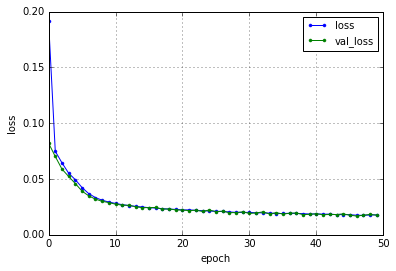

In [6]:
# define SaveFileName
SaveFileNameEncord='All_encoded'
SaveFileNameDecord='All_decoded'
SaveFileNameNet='All_net'
SaveFileNameTrain='All_train'
SaveFileNameTest='All_test'
SaveFileNameGlaph=GlaphDataPath+'All_loss_val_loss.png'

windoW = window
col = windoW.shape[1]
row = windoW.shape[2]
shapeNum=col*row

window_train=windoW.reshape((len(windoW),np.prod(windoW.shape[1:])))
window_test=windoW.reshape((len(windoW),np.prod(windoW.shape[1:])))

processing.SaveDicDataFromFileNPZ(WindowDataPath,SaveFileNameTrain,window_test)
processing.SaveDicDataFromFileNPZ(WindowDataPath,SaveFileNameTest,window_test)

encoding_dim = 8  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(shapeNum,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='tanh')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(shapeNum, activation='linear')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input=input_img, output=decoded)

# this model maps an input to its encoded representation
encoder = Model(input=input_img, output=encoded)

# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(input=encoded_input, output=decoder_layer(encoded_input))

autoencoder.compile(optimizer='adadelta', loss='mse')

hist = autoencoder.fit(window_train, window_train,
                nb_epoch=50,
                batch_size=shapeNum/4,
                shuffle=True,
                validation_data=(window_test, window_test))

encoded_imgs = encoder.predict(window_test)
decoded_imgs = decoder.predict(encoded_imgs)

processing.SaveDicDataFromFileNPZ(StudyDataPath,SaveFileNameEncord,encoded_imgs)
processing.SaveDicDataFromFileNPZ(StudyDataPath,SaveFileNameDecord,decoded_imgs)

# save model and wights
json_string = encoder.to_json()
open(StudyDataPath+SaveFileNameEncord+'.json', 'w').write(json_string)
encoder.save_weights(StudyDataPath+SaveFileNameEncord+'_weights.h5')

json_string = decoder.to_json()
open(StudyDataPath+SaveFileNameDecord+'.json', 'w').write(json_string)
decoder.save_weights(StudyDataPath+SaveFileNameDecord+'_weights.h5')

json_string = autoencoder.to_json()
open(StudyDataPath+SaveFileNameNet+'.json', 'w').write(json_string)
autoencoder.save_weights(StudyDataPath+SaveFileNameNet+'_weights.h5')

# plot loss
loss = hist.history['loss']
val_loss = hist.history['val_loss']

nb_epoch = len(loss)
plt.plot(range(nb_epoch), loss, marker='.', label='loss')
plt.plot(range(nb_epoch), val_loss, marker='.', label='val_loss')
plt.legend(loc='best', fontsize=10)
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.savefig(SaveFileNameGlaph)
plt.show()

それぞれのセンサの加速度でX軸のみをAutoEncoderにかける

In [9]:
wi = WIN.Window()
wi.SetData('dic1-AccX',dic1['AccX'])
window = wi.Compile(windowWidth=16,overlap=0.5)

dic1-AccX is registed now
Build Complete
(254742,)


Train on 15921 samples, validate on 15921 samples
Epoch 1/50
15921/15921 [==============================] - 4s - loss: 0.0325 - val_loss: 0.0033
Epoch 2/50
15921/15921 [==============================] - 4s - loss: 0.0026 - val_loss: 0.0019
Epoch 3/50
15921/15921 [==============================] - 4s - loss: 0.0016 - val_loss: 0.0016
Epoch 4/50
15921/15921 [==============================] - 4s - loss: 0.0010 - val_loss: 7.8746e-04
Epoch 5/50
15921/15921 [==============================] - 4s - loss: 7.0639e-04 - val_loss: 5.9802e-04
Epoch 6/50
15921/15921 [==============================] - 4s - loss: 5.4911e-04 - val_loss: 4.4867e-04
Epoch 7/50
15921/15921 [==============================] - 4s - loss: 4.6895e-04 - val_loss: 3.8734e-04
Epoch 8/50
15921/15921 [==============================] - 4s - loss: 4.1528e-04 - val_loss: 3.4474e-04
Epoch 9/50
15921/15921 [==============================] - 4s - loss: 3.7855e-04 - val_loss: 3.3072e-04
Epoch 10/50
15921/15921 [==========================

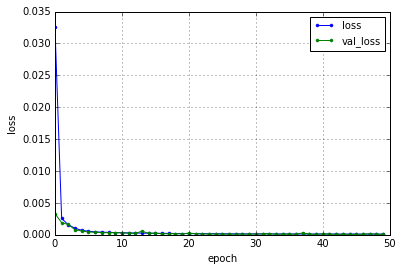

In [10]:
# define SaveFileName
SaveFileNameEncord='sensor1_AccX_encoded'
SaveFileNameDecord='sensor1_AccX_decoded'
SaveFileNameNet='sensor1_AccX_net'
SaveFileNameTrain='sensor1_AccX_train'
SaveFileNameTest='sensor1_AccX_test'
SaveFileNameGlaph=GlaphDataPath+'sensor1_AccX_loss_val_loss.png'

windoW = window
col = windoW.shape[1]
row = windoW.shape[2]
shapeNum=col*row

window_train=windoW.reshape((len(windoW),np.prod(windoW.shape[1:])))
window_test=windoW.reshape((len(windoW),np.prod(windoW.shape[1:])))

processing.SaveDicDataFromFileNPZ(WindowDataPath,SaveFileNameTrain,window_test)
processing.SaveDicDataFromFileNPZ(WindowDataPath,SaveFileNameTest,window_test)

encoding_dim = 8  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(shapeNum,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='tanh')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(shapeNum, activation='linear')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input=input_img, output=decoded)

# this model maps an input to its encoded representation
encoder = Model(input=input_img, output=encoded)

# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(input=encoded_input, output=decoder_layer(encoded_input))

autoencoder.compile(optimizer='adadelta', loss='mse')

hist = autoencoder.fit(window_train, window_train,
                nb_epoch=50,
                batch_size=shapeNum/4,
                shuffle=True,
                validation_data=(window_test, window_test))

encoded_imgs = encoder.predict(window_test)
decoded_imgs = decoder.predict(encoded_imgs)

processing.SaveDicDataFromFileNPZ(StudyDataPath,SaveFileNameEncord,encoded_imgs)
processing.SaveDicDataFromFileNPZ(StudyDataPath,SaveFileNameDecord,decoded_imgs)

# save model and wights
json_string = encoder.to_json()
open(StudyDataPath+SaveFileNameEncord+'.json', 'w').write(json_string)
encoder.save_weights(StudyDataPath+SaveFileNameEncord+'_weights.h5')

json_string = decoder.to_json()
open(StudyDataPath+SaveFileNameDecord+'.json', 'w').write(json_string)
decoder.save_weights(StudyDataPath+SaveFileNameDecord+'_weights.h5')

json_string = autoencoder.to_json()
open(StudyDataPath+SaveFileNameNet+'.json', 'w').write(json_string)
autoencoder.save_weights(StudyDataPath+SaveFileNameNet+'_weights.h5')

# plot loss
loss = hist.history['loss']
val_loss = hist.history['val_loss']

nb_epoch = len(loss)
plt.plot(range(nb_epoch), loss, marker='.', label='loss')
plt.plot(range(nb_epoch), val_loss, marker='.', label='val_loss')
plt.legend(loc='best', fontsize=10)
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.savefig(SaveFileNameGlaph)
plt.show()

dic2-AccX is registed now
Build Complete
(254742,)
Train on 15921 samples, validate on 15921 samples
Epoch 1/50
15921/15921 [==============================] - 4s - loss: 0.0282 - val_loss: 0.0023
Epoch 2/50
15921/15921 [==============================] - 4s - loss: 0.0017 - val_loss: 0.0014
Epoch 3/50
15921/15921 [==============================] - 4s - loss: 0.0012 - val_loss: 0.0010
Epoch 4/50
15921/15921 [==============================] - 4s - loss: 9.0577e-04 - val_loss: 8.4455e-04
Epoch 5/50
15921/15921 [==============================] - 4s - loss: 6.7520e-04 - val_loss: 5.5927e-04
Epoch 6/50
15921/15921 [==============================] - 4s - loss: 5.2423e-04 - val_loss: 5.5510e-04
Epoch 7/50
15921/15921 [==============================] - 4s - loss: 4.4063e-04 - val_loss: 3.8665e-04
Epoch 8/50
15921/15921 [==============================] - 4s - loss: 3.9192e-04 - val_loss: 4.2416e-04
Epoch 9/50
15921/15921 [==============================] - 4s - loss: 3.6263e-04 - val_loss: 4.1304e

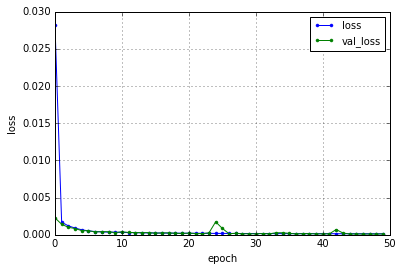

In [12]:
wi = WIN.Window()
wi.SetData('dic2-AccX',dic2['AccX'])
window = wi.Compile(windowWidth=16,overlap=0.5)

# define SaveFileName
SensorName= 'sensor2'
SaveFileNameEncord=SensorName+'_AccX_encoded'
SaveFileNameDecord=SensorName+'_AccX_decoded'
SaveFileNameNet=SensorName+'_AccX_net'
SaveFileNameTrain=SensorName+'_AccX_train'
SaveFileNameTest=SensorName+'_AccX_test'
SaveFileNameGlaph=GlaphDataPath+SensorName+'_AccX_loss_val_loss.png'

windoW = window
col = windoW.shape[1]
row = windoW.shape[2]
shapeNum=col*row

window_train=windoW.reshape((len(windoW),np.prod(windoW.shape[1:])))
window_test=windoW.reshape((len(windoW),np.prod(windoW.shape[1:])))

processing.SaveDicDataFromFileNPZ(WindowDataPath,SaveFileNameTrain,window_test)
processing.SaveDicDataFromFileNPZ(WindowDataPath,SaveFileNameTest,window_test)

encoding_dim = 8  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(shapeNum,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='tanh')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(shapeNum, activation='linear')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input=input_img, output=decoded)

# this model maps an input to its encoded representation
encoder = Model(input=input_img, output=encoded)

# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(input=encoded_input, output=decoder_layer(encoded_input))

autoencoder.compile(optimizer='adadelta', loss='mse')

hist = autoencoder.fit(window_train, window_train,
                nb_epoch=50,
                batch_size=shapeNum/4,
                shuffle=True,
                validation_data=(window_test, window_test))

encoded_imgs = encoder.predict(window_test)
decoded_imgs = decoder.predict(encoded_imgs)

processing.SaveDicDataFromFileNPZ(StudyDataPath,SaveFileNameEncord,encoded_imgs)
processing.SaveDicDataFromFileNPZ(StudyDataPath,SaveFileNameDecord,decoded_imgs)

# save model and wights
json_string = encoder.to_json()
open(StudyDataPath+SaveFileNameEncord+'.json', 'w').write(json_string)
encoder.save_weights(StudyDataPath+SaveFileNameEncord+'_weights.h5')

json_string = decoder.to_json()
open(StudyDataPath+SaveFileNameDecord+'.json', 'w').write(json_string)
decoder.save_weights(StudyDataPath+SaveFileNameDecord+'_weights.h5')

json_string = autoencoder.to_json()
open(StudyDataPath+SaveFileNameNet+'.json', 'w').write(json_string)
autoencoder.save_weights(StudyDataPath+SaveFileNameNet+'_weights.h5')

# plot loss
loss = hist.history['loss']
val_loss = hist.history['val_loss']

nb_epoch = len(loss)
plt.plot(range(nb_epoch), loss, marker='.', label='loss')
plt.plot(range(nb_epoch), val_loss, marker='.', label='val_loss')
plt.legend(loc='best', fontsize=10)
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.savefig(SaveFileNameGlaph)
plt.show()

dic3-AccX is registed now
Build Complete
(254742,)
Train on 15921 samples, validate on 15921 samples
Epoch 1/50
15921/15921 [==============================] - 4s - loss: 0.0476 - val_loss: 0.0040
Epoch 2/50
15921/15921 [==============================] - 4s - loss: 0.0029 - val_loss: 0.0023
Epoch 3/50
15921/15921 [==============================] - 4s - loss: 0.0019 - val_loss: 0.0015
Epoch 4/50
15921/15921 [==============================] - 4s - loss: 0.0013 - val_loss: 0.0014
Epoch 5/50
15921/15921 [==============================] - 4s - loss: 8.9908e-04 - val_loss: 7.3840e-04
Epoch 6/50
15921/15921 [==============================] - 4s - loss: 6.7791e-04 - val_loss: 5.5587e-04
Epoch 7/50
15921/15921 [==============================] - 4s - loss: 5.7598e-04 - val_loss: 0.0021
Epoch 8/50
15921/15921 [==============================] - 4s - loss: 5.1063e-04 - val_loss: 4.4320e-04
Epoch 9/50
15921/15921 [==============================] - 4s - loss: 4.7967e-04 - val_loss: 4.1933e-04
Epoch 10

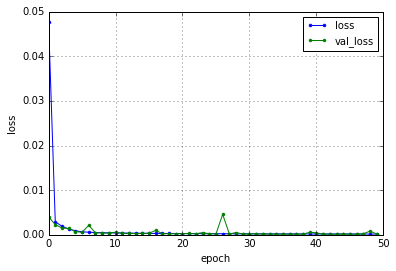

In [13]:
wi = WIN.Window()
wi.SetData('dic3-AccX',dic3['AccX'])
window = wi.Compile(windowWidth=16,overlap=0.5)

# define SaveFileName
SensorName= 'sensor3'
SaveFileNameEncord=SensorName+'_AccX_encoded'
SaveFileNameDecord=SensorName+'_AccX_decoded'
SaveFileNameNet=SensorName+'_AccX_net'
SaveFileNameTrain=SensorName+'_AccX_train'
SaveFileNameTest=SensorName+'_AccX_test'
SaveFileNameGlaph=GlaphDataPath+SensorName+'_AccX_loss_val_loss.png'

windoW = window
col = windoW.shape[1]
row = windoW.shape[2]
shapeNum=col*row

window_train=windoW.reshape((len(windoW),np.prod(windoW.shape[1:])))
window_test=windoW.reshape((len(windoW),np.prod(windoW.shape[1:])))

processing.SaveDicDataFromFileNPZ(WindowDataPath,SaveFileNameTrain,window_test)
processing.SaveDicDataFromFileNPZ(WindowDataPath,SaveFileNameTest,window_test)

encoding_dim = 8  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(shapeNum,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='tanh')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(shapeNum, activation='linear')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input=input_img, output=decoded)

# this model maps an input to its encoded representation
encoder = Model(input=input_img, output=encoded)

# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(input=encoded_input, output=decoder_layer(encoded_input))

autoencoder.compile(optimizer='adadelta', loss='mse')

hist = autoencoder.fit(window_train, window_train,
                nb_epoch=50,
                batch_size=shapeNum/4,
                shuffle=True,
                validation_data=(window_test, window_test))

encoded_imgs = encoder.predict(window_test)
decoded_imgs = decoder.predict(encoded_imgs)

processing.SaveDicDataFromFileNPZ(StudyDataPath,SaveFileNameEncord,encoded_imgs)
processing.SaveDicDataFromFileNPZ(StudyDataPath,SaveFileNameDecord,decoded_imgs)

# save model and wights
json_string = encoder.to_json()
open(StudyDataPath+SaveFileNameEncord+'.json', 'w').write(json_string)
encoder.save_weights(StudyDataPath+SaveFileNameEncord+'_weights.h5')

json_string = decoder.to_json()
open(StudyDataPath+SaveFileNameDecord+'.json', 'w').write(json_string)
decoder.save_weights(StudyDataPath+SaveFileNameDecord+'_weights.h5')

json_string = autoencoder.to_json()
open(StudyDataPath+SaveFileNameNet+'.json', 'w').write(json_string)
autoencoder.save_weights(StudyDataPath+SaveFileNameNet+'_weights.h5')

# plot loss
loss = hist.history['loss']
val_loss = hist.history['val_loss']

nb_epoch = len(loss)
plt.plot(range(nb_epoch), loss, marker='.', label='loss')
plt.plot(range(nb_epoch), val_loss, marker='.', label='val_loss')
plt.legend(loc='best', fontsize=10)
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.savefig(SaveFileNameGlaph)
plt.show()

dic4-AccX is registed now
Build Complete
(254742,)
Train on 15921 samples, validate on 15921 samples
Epoch 1/50
15921/15921 [==============================] - 4s - loss: 0.0564 - val_loss: 0.0043
Epoch 2/50
15921/15921 [==============================] - 4s - loss: 0.0033 - val_loss: 0.0025
Epoch 3/50
15921/15921 [==============================] - 4s - loss: 0.0020 - val_loss: 0.0016
Epoch 4/50
15921/15921 [==============================] - 4s - loss: 0.0014 - val_loss: 0.0012
Epoch 5/50
15921/15921 [==============================] - 4s - loss: 0.0011 - val_loss: 9.8485e-04
Epoch 6/50
15921/15921 [==============================] - 4s - loss: 9.3821e-04 - val_loss: 9.1352e-04
Epoch 7/50
15921/15921 [==============================] - 4s - loss: 8.3534e-04 - val_loss: 7.5150e-04
Epoch 8/50
15921/15921 [==============================] - 4s - loss: 7.5275e-04 - val_loss: 6.6918e-04
Epoch 9/50
15921/15921 [==============================] - 4s - loss: 6.7725e-04 - val_loss: 6.0697e-04
Epoch 10

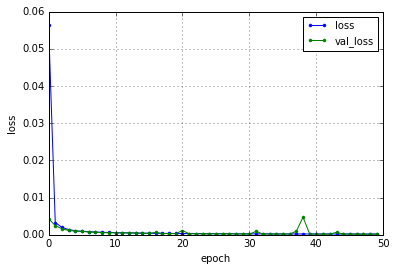

In [14]:
wi = WIN.Window()
wi.SetData('dic4-AccX',dic4['AccX'])
window = wi.Compile(windowWidth=16,overlap=0.5)

# define SaveFileName
SensorName= 'sensor4'
SaveFileNameEncord=SensorName+'_AccX_encoded'
SaveFileNameDecord=SensorName+'_AccX_decoded'
SaveFileNameNet=SensorName+'_AccX_net'
SaveFileNameTrain=SensorName+'_AccX_train'
SaveFileNameTest=SensorName+'_AccX_test'
SaveFileNameGlaph=GlaphDataPath+SensorName+'_AccX_loss_val_loss.png'

windoW = window
col = windoW.shape[1]
row = windoW.shape[2]
shapeNum=col*row

window_train=windoW.reshape((len(windoW),np.prod(windoW.shape[1:])))
window_test=windoW.reshape((len(windoW),np.prod(windoW.shape[1:])))

processing.SaveDicDataFromFileNPZ(WindowDataPath,SaveFileNameTrain,window_test)
processing.SaveDicDataFromFileNPZ(WindowDataPath,SaveFileNameTest,window_test)

encoding_dim = 8  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(shapeNum,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='tanh')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(shapeNum, activation='linear')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input=input_img, output=decoded)

# this model maps an input to its encoded representation
encoder = Model(input=input_img, output=encoded)

# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(input=encoded_input, output=decoder_layer(encoded_input))

autoencoder.compile(optimizer='adadelta', loss='mse')

hist = autoencoder.fit(window_train, window_train,
                nb_epoch=50,
                batch_size=shapeNum/4,
                shuffle=True,
                validation_data=(window_test, window_test))

encoded_imgs = encoder.predict(window_test)
decoded_imgs = decoder.predict(encoded_imgs)

processing.SaveDicDataFromFileNPZ(StudyDataPath,SaveFileNameEncord,encoded_imgs)
processing.SaveDicDataFromFileNPZ(StudyDataPath,SaveFileNameDecord,decoded_imgs)

# save model and wights
json_string = encoder.to_json()
open(StudyDataPath+SaveFileNameEncord+'.json', 'w').write(json_string)
encoder.save_weights(StudyDataPath+SaveFileNameEncord+'_weights.h5')

json_string = decoder.to_json()
open(StudyDataPath+SaveFileNameDecord+'.json', 'w').write(json_string)
decoder.save_weights(StudyDataPath+SaveFileNameDecord+'_weights.h5')

json_string = autoencoder.to_json()
open(StudyDataPath+SaveFileNameNet+'.json', 'w').write(json_string)
autoencoder.save_weights(StudyDataPath+SaveFileNameNet+'_weights.h5')

# plot loss
loss = hist.history['loss']
val_loss = hist.history['val_loss']

nb_epoch = len(loss)
plt.plot(range(nb_epoch), loss, marker='.', label='loss')
plt.plot(range(nb_epoch), val_loss, marker='.', label='val_loss')
plt.legend(loc='best', fontsize=10)
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.savefig(SaveFileNameGlaph)
plt.show()

dic5-AccX is registed now
Build Complete
(254742,)
Train on 15921 samples, validate on 15921 samples
Epoch 1/50
15921/15921 [==============================] - 4s - loss: 0.0127 - val_loss: 6.4501e-04
Epoch 2/50
15921/15921 [==============================] - 4s - loss: 5.6842e-04 - val_loss: 4.6287e-04
Epoch 3/50
15921/15921 [==============================] - 4s - loss: 4.2369e-04 - val_loss: 3.5162e-04
Epoch 4/50
15921/15921 [==============================] - 4s - loss: 3.3529e-04 - val_loss: 3.2941e-04
Epoch 5/50
15921/15921 [==============================] - 4s - loss: 2.7673e-04 - val_loss: 2.3582e-04
Epoch 6/50
15921/15921 [==============================] - 4s - loss: 2.3587e-04 - val_loss: 2.2651e-04
Epoch 7/50
15921/15921 [==============================] - 4s - loss: 2.0271e-04 - val_loss: 3.4160e-04
Epoch 8/50
15921/15921 [==============================] - 4s - loss: 1.7550e-04 - val_loss: 1.6050e-04
Epoch 9/50
15921/15921 [==============================] - 4s - loss: 1.5098e-04

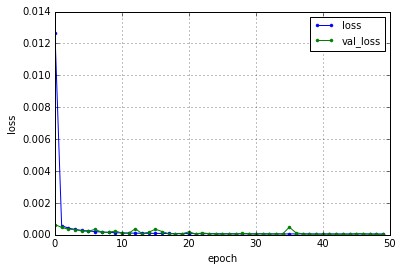

In [15]:
wi = WIN.Window()
wi.SetData('dic5-AccX',dic5['AccX'])
window = wi.Compile(windowWidth=16,overlap=0.5)

# define SaveFileName
SensorName= 'sensor5'
SaveFileNameEncord=SensorName+'_AccX_encoded'
SaveFileNameDecord=SensorName+'_AccX_decoded'
SaveFileNameNet=SensorName+'_AccX_net'
SaveFileNameTrain=SensorName+'_AccX_train'
SaveFileNameTest=SensorName+'_AccX_test'
SaveFileNameGlaph=GlaphDataPath+SensorName+'_AccX_loss_val_loss.png'

windoW = window
col = windoW.shape[1]
row = windoW.shape[2]
shapeNum=col*row

window_train=windoW.reshape((len(windoW),np.prod(windoW.shape[1:])))
window_test=windoW.reshape((len(windoW),np.prod(windoW.shape[1:])))

processing.SaveDicDataFromFileNPZ(WindowDataPath,SaveFileNameTrain,window_test)
processing.SaveDicDataFromFileNPZ(WindowDataPath,SaveFileNameTest,window_test)

encoding_dim = 8  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(shapeNum,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='tanh')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(shapeNum, activation='linear')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input=input_img, output=decoded)

# this model maps an input to its encoded representation
encoder = Model(input=input_img, output=encoded)

# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(input=encoded_input, output=decoder_layer(encoded_input))

autoencoder.compile(optimizer='adadelta', loss='mse')

hist = autoencoder.fit(window_train, window_train,
                nb_epoch=50,
                batch_size=shapeNum/4,
                shuffle=True,
                validation_data=(window_test, window_test))

encoded_imgs = encoder.predict(window_test)
decoded_imgs = decoder.predict(encoded_imgs)

processing.SaveDicDataFromFileNPZ(StudyDataPath,SaveFileNameEncord,encoded_imgs)
processing.SaveDicDataFromFileNPZ(StudyDataPath,SaveFileNameDecord,decoded_imgs)

# save model and wights
json_string = encoder.to_json()
open(StudyDataPath+SaveFileNameEncord+'.json', 'w').write(json_string)
encoder.save_weights(StudyDataPath+SaveFileNameEncord+'_weights.h5')

json_string = decoder.to_json()
open(StudyDataPath+SaveFileNameDecord+'.json', 'w').write(json_string)
decoder.save_weights(StudyDataPath+SaveFileNameDecord+'_weights.h5')

json_string = autoencoder.to_json()
open(StudyDataPath+SaveFileNameNet+'.json', 'w').write(json_string)
autoencoder.save_weights(StudyDataPath+SaveFileNameNet+'_weights.h5')

# plot loss
loss = hist.history['loss']
val_loss = hist.history['val_loss']

nb_epoch = len(loss)
plt.plot(range(nb_epoch), loss, marker='.', label='loss')
plt.plot(range(nb_epoch), val_loss, marker='.', label='val_loss')
plt.legend(loc='best', fontsize=10)
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.savefig(SaveFileNameGlaph)
plt.show()

dic6-AccX is registed now
Build Complete
(254742,)
Train on 15921 samples, validate on 15921 samples
Epoch 1/50
15921/15921 [==============================] - 4s - loss: 0.0206 - val_loss: 0.0019
Epoch 2/50
15921/15921 [==============================] - 4s - loss: 0.0017 - val_loss: 0.0017
Epoch 3/50
15921/15921 [==============================] - 4s - loss: 0.0013 - val_loss: 0.0012
Epoch 4/50
15921/15921 [==============================] - 4s - loss: 0.0011 - val_loss: 9.7559e-04
Epoch 5/50
15921/15921 [==============================] - 4s - loss: 9.1709e-04 - val_loss: 8.1664e-04
Epoch 6/50
15921/15921 [==============================] - 4s - loss: 7.7017e-04 - val_loss: 7.1202e-04
Epoch 7/50
15921/15921 [==============================] - 4s - loss: 6.9505e-04 - val_loss: 7.1788e-04
Epoch 8/50
15921/15921 [==============================] - 4s - loss: 6.5056e-04 - val_loss: 6.1571e-04
Epoch 9/50
15921/15921 [==============================] - 4s - loss: 6.1277e-04 - val_loss: 5.8190e-04


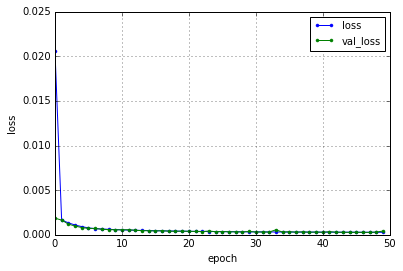

In [16]:
wi = WIN.Window()
wi.SetData('dic6-AccX',dic6['AccX'])
window = wi.Compile(windowWidth=16,overlap=0.5)

# define SaveFileName
SensorName= 'sensor6'
SaveFileNameEncord=SensorName+'_AccX_encoded'
SaveFileNameDecord=SensorName+'_AccX_decoded'
SaveFileNameNet=SensorName+'_AccX_net'
SaveFileNameTrain=SensorName+'_AccX_train'
SaveFileNameTest=SensorName+'_AccX_test'
SaveFileNameGlaph=GlaphDataPath+SensorName+'_AccX_loss_val_loss.png'

windoW = window
col = windoW.shape[1]
row = windoW.shape[2]
shapeNum=col*row

window_train=windoW.reshape((len(windoW),np.prod(windoW.shape[1:])))
window_test=windoW.reshape((len(windoW),np.prod(windoW.shape[1:])))

processing.SaveDicDataFromFileNPZ(WindowDataPath,SaveFileNameTrain,window_test)
processing.SaveDicDataFromFileNPZ(WindowDataPath,SaveFileNameTest,window_test)

encoding_dim = 8  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(shapeNum,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='tanh')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(shapeNum, activation='linear')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input=input_img, output=decoded)

# this model maps an input to its encoded representation
encoder = Model(input=input_img, output=encoded)

# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(input=encoded_input, output=decoder_layer(encoded_input))

autoencoder.compile(optimizer='adadelta', loss='mse')

hist = autoencoder.fit(window_train, window_train,
                nb_epoch=50,
                batch_size=shapeNum/4,
                shuffle=True,
                validation_data=(window_test, window_test))

encoded_imgs = encoder.predict(window_test)
decoded_imgs = decoder.predict(encoded_imgs)

processing.SaveDicDataFromFileNPZ(StudyDataPath,SaveFileNameEncord,encoded_imgs)
processing.SaveDicDataFromFileNPZ(StudyDataPath,SaveFileNameDecord,decoded_imgs)

# save model and wights
json_string = encoder.to_json()
open(StudyDataPath+SaveFileNameEncord+'.json', 'w').write(json_string)
encoder.save_weights(StudyDataPath+SaveFileNameEncord+'_weights.h5')

json_string = decoder.to_json()
open(StudyDataPath+SaveFileNameDecord+'.json', 'w').write(json_string)
decoder.save_weights(StudyDataPath+SaveFileNameDecord+'_weights.h5')

json_string = autoencoder.to_json()
open(StudyDataPath+SaveFileNameNet+'.json', 'w').write(json_string)
autoencoder.save_weights(StudyDataPath+SaveFileNameNet+'_weights.h5')

# plot loss
loss = hist.history['loss']
val_loss = hist.history['val_loss']

nb_epoch = len(loss)
plt.plot(range(nb_epoch), loss, marker='.', label='loss')
plt.plot(range(nb_epoch), val_loss, marker='.', label='val_loss')
plt.legend(loc='best', fontsize=10)
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.savefig(SaveFileNameGlaph)
plt.show()

dic7-AccX is registed now
Build Complete
(254742,)
Train on 15921 samples, validate on 15921 samples
Epoch 1/50
15921/15921 [==============================] - 4s - loss: 0.0085 - val_loss: 4.9438e-04
Epoch 2/50
15921/15921 [==============================] - 4s - loss: 3.8095e-04 - val_loss: 3.1563e-04
Epoch 3/50
15921/15921 [==============================] - 4s - loss: 2.9802e-04 - val_loss: 2.8855e-04
Epoch 4/50
15921/15921 [==============================] - 4s - loss: 2.5194e-04 - val_loss: 2.3769e-04
Epoch 5/50
15921/15921 [==============================] - 4s - loss: 2.1954e-04 - val_loss: 2.4361e-04
Epoch 6/50
15921/15921 [==============================] - 4s - loss: 1.9482e-04 - val_loss: 1.7655e-04
Epoch 7/50
15921/15921 [==============================] - 4s - loss: 1.7602e-04 - val_loss: 1.5938e-04
Epoch 8/50
15921/15921 [==============================] - 4s - loss: 1.6112e-04 - val_loss: 3.1016e-04
Epoch 9/50
15921/15921 [==============================] - 4s - loss: 1.4969e-04

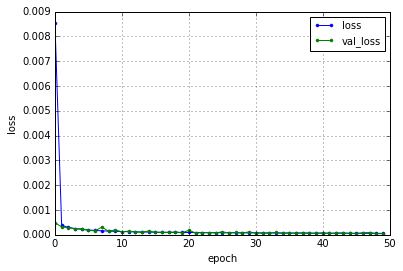

In [17]:
wi = WIN.Window()
wi.SetData('dic7-AccX',dic7['AccX'])
window = wi.Compile(windowWidth=16,overlap=0.5)

# define SaveFileName
SensorName= 'sensor7'
SaveFileNameEncord=SensorName+'_AccX_encoded'
SaveFileNameDecord=SensorName+'_AccX_decoded'
SaveFileNameNet=SensorName+'_AccX_net'
SaveFileNameTrain=SensorName+'_AccX_train'
SaveFileNameTest=SensorName+'_AccX_test'
SaveFileNameGlaph=GlaphDataPath+SensorName+'_AccX_loss_val_loss.png'

windoW = window
col = windoW.shape[1]
row = windoW.shape[2]
shapeNum=col*row

window_train=windoW.reshape((len(windoW),np.prod(windoW.shape[1:])))
window_test=windoW.reshape((len(windoW),np.prod(windoW.shape[1:])))

processing.SaveDicDataFromFileNPZ(WindowDataPath,SaveFileNameTrain,window_test)
processing.SaveDicDataFromFileNPZ(WindowDataPath,SaveFileNameTest,window_test)

encoding_dim = 8  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(shapeNum,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='tanh')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(shapeNum, activation='linear')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input=input_img, output=decoded)

# this model maps an input to its encoded representation
encoder = Model(input=input_img, output=encoded)

# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(input=encoded_input, output=decoder_layer(encoded_input))

autoencoder.compile(optimizer='adadelta', loss='mse')

hist = autoencoder.fit(window_train, window_train,
                nb_epoch=50,
                batch_size=shapeNum/4,
                shuffle=True,
                validation_data=(window_test, window_test))

encoded_imgs = encoder.predict(window_test)
decoded_imgs = decoder.predict(encoded_imgs)

processing.SaveDicDataFromFileNPZ(StudyDataPath,SaveFileNameEncord,encoded_imgs)
processing.SaveDicDataFromFileNPZ(StudyDataPath,SaveFileNameDecord,decoded_imgs)

# save model and wights
json_string = encoder.to_json()
open(StudyDataPath+SaveFileNameEncord+'.json', 'w').write(json_string)
encoder.save_weights(StudyDataPath+SaveFileNameEncord+'_weights.h5')

json_string = decoder.to_json()
open(StudyDataPath+SaveFileNameDecord+'.json', 'w').write(json_string)
decoder.save_weights(StudyDataPath+SaveFileNameDecord+'_weights.h5')

json_string = autoencoder.to_json()
open(StudyDataPath+SaveFileNameNet+'.json', 'w').write(json_string)
autoencoder.save_weights(StudyDataPath+SaveFileNameNet+'_weights.h5')

# plot loss
loss = hist.history['loss']
val_loss = hist.history['val_loss']

nb_epoch = len(loss)
plt.plot(range(nb_epoch), loss, marker='.', label='loss')
plt.plot(range(nb_epoch), val_loss, marker='.', label='val_loss')
plt.legend(loc='best', fontsize=10)
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.savefig(SaveFileNameGlaph)
plt.show()